**自动求导**

*对 y = 2 x ⊤ x 函数关于列向量x求导*

In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

需要申请内存存储梯度

In [2]:
# 函数后加_ 表示重新写入
x.requires_grad_(True) # 等价于 x = torch.arange(4.0, requires_grad=True)
x.grad # 初始默认为None

In [3]:
y = 2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

In [4]:
y.backward()

x.grad

tensor([ 0.,  4.,  8., 12.])

In [5]:
x.grad == 4 * x

tensor([True, True, True, True])

计算`x`的另一个函数

In [6]:
# 默认情况下，pytorch会累积梯度
# x.grad.zeros_() 将梯度清零
y = x.sum()
y.backward()
x.grad

tensor([ 1.,  5.,  9., 13.])

In [7]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

计算批量中每个样本单独计算的偏导数

In [8]:
x.grad.zero_()
y = x * x
y.sum().backward() # 转化为标量
x.grad

tensor([0., 2., 4., 6.])

**将某些计算移动到计算图之外**

In [9]:
x.grad.zero_()
y = x * x
u = y.detach() 
# detach() —— > 转化为定值,此处就将y看作定值，而非变量，从而不参与计算图
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2*x

tensor([True, True, True, True])

***即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用）
仍然可以计算得到的变量的梯度***

In [11]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True) # size=() --- 创建标量
d = f(a)
d.backward()

a.grad, a.grad == d / a

(tensor(102400.), tensor(True))

***练习***
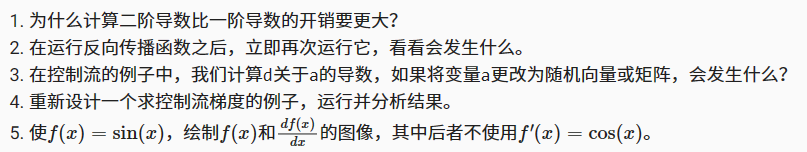

In [12]:
# QA1: 二阶导数在一阶导数基础上进行的
# QA2
X = torch.randn(4,4,requires_grad=True)

In [13]:
Y = X.T * X
Y.sum().backward(retain_graph=True)
X.grad

tensor([[-0.0891,  1.6297,  1.3905, -0.4432],
        [-1.4145, -1.6389, -1.7434,  1.5159],
        [-1.6127, -1.1651,  2.9713,  0.0163],
        [-1.2029,  0.4102,  1.4530, -1.0862]])

In [14]:
"""
Y.sum().backward()
X.grad
报错:
Trying to backward through the graph a second time
Specify retain_graph=True if you need to backward through the graph a second time 
or if you need to access saved tensors after calling backward.

"""
# 解决:上次的backward()改为backward(retain_graph=True)
Y.sum().backward()
X.grad

tensor([[-0.1782,  3.2593,  2.7810, -0.8864],
        [-2.8290, -3.2778, -3.4868,  3.0319],
        [-3.2254, -2.3301,  5.9427,  0.0327],
        [-2.4058,  0.8204,  2.9061, -2.1723]])

In [15]:
# QA3
a = torch.randn(2,3,4,requires_grad=True)
b = f(a)
b.sum().backward()
a.grad

tensor([[[25600., 25600., 25600., 25600.],
         [25600., 25600., 25600., 25600.],
         [25600., 25600., 25600., 25600.]],

        [[25600., 25600., 25600., 25600.],
         [25600., 25600., 25600., 25600.],
         [25600., 25600., 25600., 25600.]]])

In [16]:
# QA4
def f1(a):
    b = 2 * a * a
    while b.norm() < 1000:
        b = b * b # 注意不能 b *= b，因为梯度要存储，不能在本地修改
    return b

a = torch.arange(1,17,dtype=torch.float32).reshape(4,4)
a.requires_grad_(True)

b = f1(a)
b.sum().backward()
a.grad, a.grad == 4 * b / a

(tensor([[1.6000e+01, 1.2800e+02, 4.3200e+02, 1.0240e+03],
         [2.0000e+03, 3.4560e+03, 5.4880e+03, 8.1920e+03],
         [1.1664e+04, 1.6000e+04, 2.1296e+04, 2.7648e+04],
         [3.5152e+04, 4.3904e+04, 5.4000e+04, 6.5536e+04]]),
 tensor([[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]))

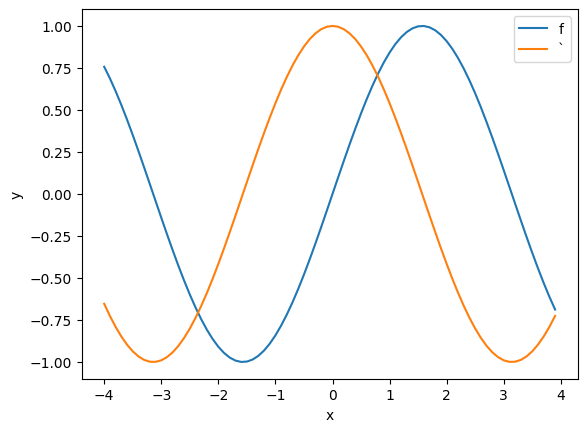

In [17]:
# QA5
import matplotlib.pyplot as plt

def f2(x):
    return torch.sin(x)

x = torch.arange(-4,4,0.1,requires_grad=True)
y = f2(x)

plot_x = x.detach().numpy()
plot_y = y.detach().numpy()

plt.figure(1)
plt.plot(plot_x,plot_y)
plt.xlabel('x')
plt.ylabel('y')
plt.legend('f(x)')

y_derivate = y.sum().backward()
plot_y_derivate = x.grad.numpy()

plt.plot(plot_x,plot_y_derivate)
plt.legend('f`(x)')

plt.show()